***IMPORT lIBRARIES***

In [128]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [129]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

***EDA***

In [130]:
train_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [131]:
test_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,NaN
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


In [132]:
print(train_df.shape)
test_df.shape

(18524, 9)


(6175, 8)

In [133]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [134]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         6175 non-null   int64  
 1   Time_spent_Alone           5750 non-null   float64
 2   Stage_fear                 5577 non-null   object 
 3   Social_event_attendance    5778 non-null   float64
 4   Going_outside              5709 non-null   float64
 5   Drained_after_socializing  5743 non-null   object 
 6   Friends_circle_size        5825 non-null   float64
 7   Post_frequency             5767 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 386.1+ KB


In [135]:
train_df.describe()

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,18524.000000,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,9261.500000,3.137764,5.265106,4.044319,7.996737,4.982097
std,5347.562529,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,9261.500000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,13892.250000,4.000000,8.000000,6.000000,12.000000,7.000000
max,18523.000000,11.000000,10.000000,7.000000,15.000000,10.000000


Handling NaNs

In [136]:
# Encode the target label: Extrovert = 1, Introvert = 0
train_df['Personality'] = train_df['Personality'].map({'Introvert': 0, 'Extrovert': 1})

# Drop the ID column 
train_df = train_df.drop(columns=['id'])

# Map 'Yes'/'No' to 1/0 in binary columns
binary_cols = ['Stage_fear', 'Drained_after_socializing']
for col in binary_cols:
    train_df[col] = train_df[col].map({'Yes': 1, 'No': 0})

# Fill missing values

# Fill binary columns with mode (1 or 0)
for col in binary_cols:
    train_df[col] = train_df[col].fillna(train_df[col].mode()[0])

# Fill numeric columns with median
numeric_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
                'Friends_circle_size', 'Post_frequency']
for col in numeric_cols:
    train_df[col] = train_df[col].fillna(train_df[col].median())

In [137]:
#Save the id column for later use
test_ids = test_df["id"]

test_df = test_df.drop(columns=['id'])

# Map 'Yes'/'No' to 1/0 in binary columns
binary_cols = ['Stage_fear', 'Drained_after_socializing']
for col in binary_cols:
    test_df[col] = test_df[col].map({'Yes': 1, 'No': 0})

# Fill missing values

# Fill binary columns with mode (1 or 0)
for col in binary_cols:
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

# Fill numeric columns with median
numeric_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
                'Friends_circle_size', 'Post_frequency']
for col in numeric_cols:
    test_df[col] = test_df[col].fillna(test_df[col].median())

In [138]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           6175 non-null   float64
 1   Stage_fear                 6175 non-null   float64
 2   Social_event_attendance    6175 non-null   float64
 3   Going_outside              6175 non-null   float64
 4   Drained_after_socializing  6175 non-null   float64
 5   Friends_circle_size        6175 non-null   float64
 6   Post_frequency             6175 non-null   float64
dtypes: float64(7)
memory usage: 337.8 KB


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


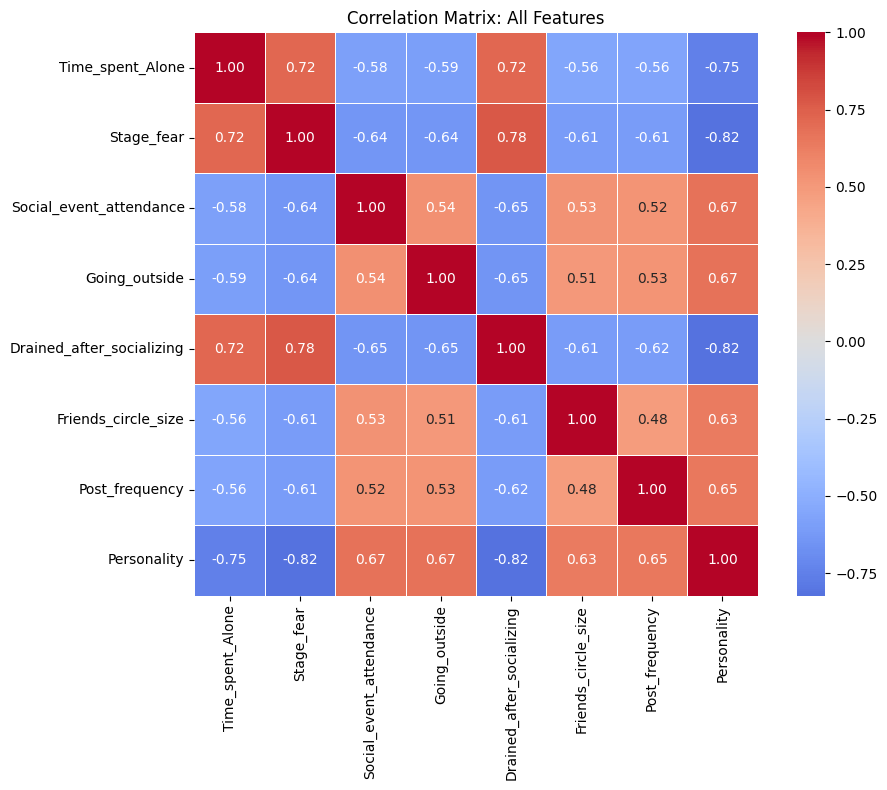

In [139]:
# Compute correlation matrix
corr_matrix = train_df.corr()

# Plot the full correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True, linewidths=0.5)

plt.title('Correlation Matrix: All Features')
plt.tight_layout()
plt.show()

***Detect class imbalance***

Personality
1    13699
0     4825
Name: count, dtype: int64


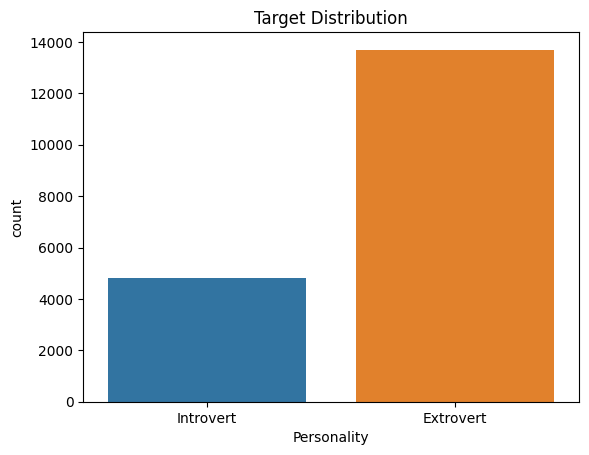

In [140]:
# Value counts
print(train_df['Personality'].value_counts())

# Plot class balance
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=train_df, x='Personality')
plt.xticks([0, 1], ['Introvert', 'Extrovert'])
plt.title('Target Distribution')
plt.show()

***Bar Plot of Correlation with Personality***

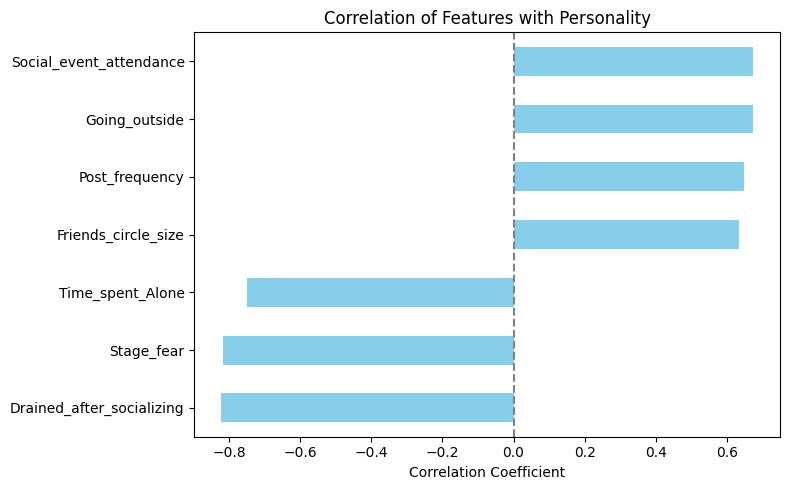

In [141]:
target_corr = train_df.corr()['Personality'].drop('Personality')

plt.figure(figsize=(8, 5))
target_corr.sort_values().plot(kind='barh', color='skyblue')
plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Correlation of Features with Personality')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

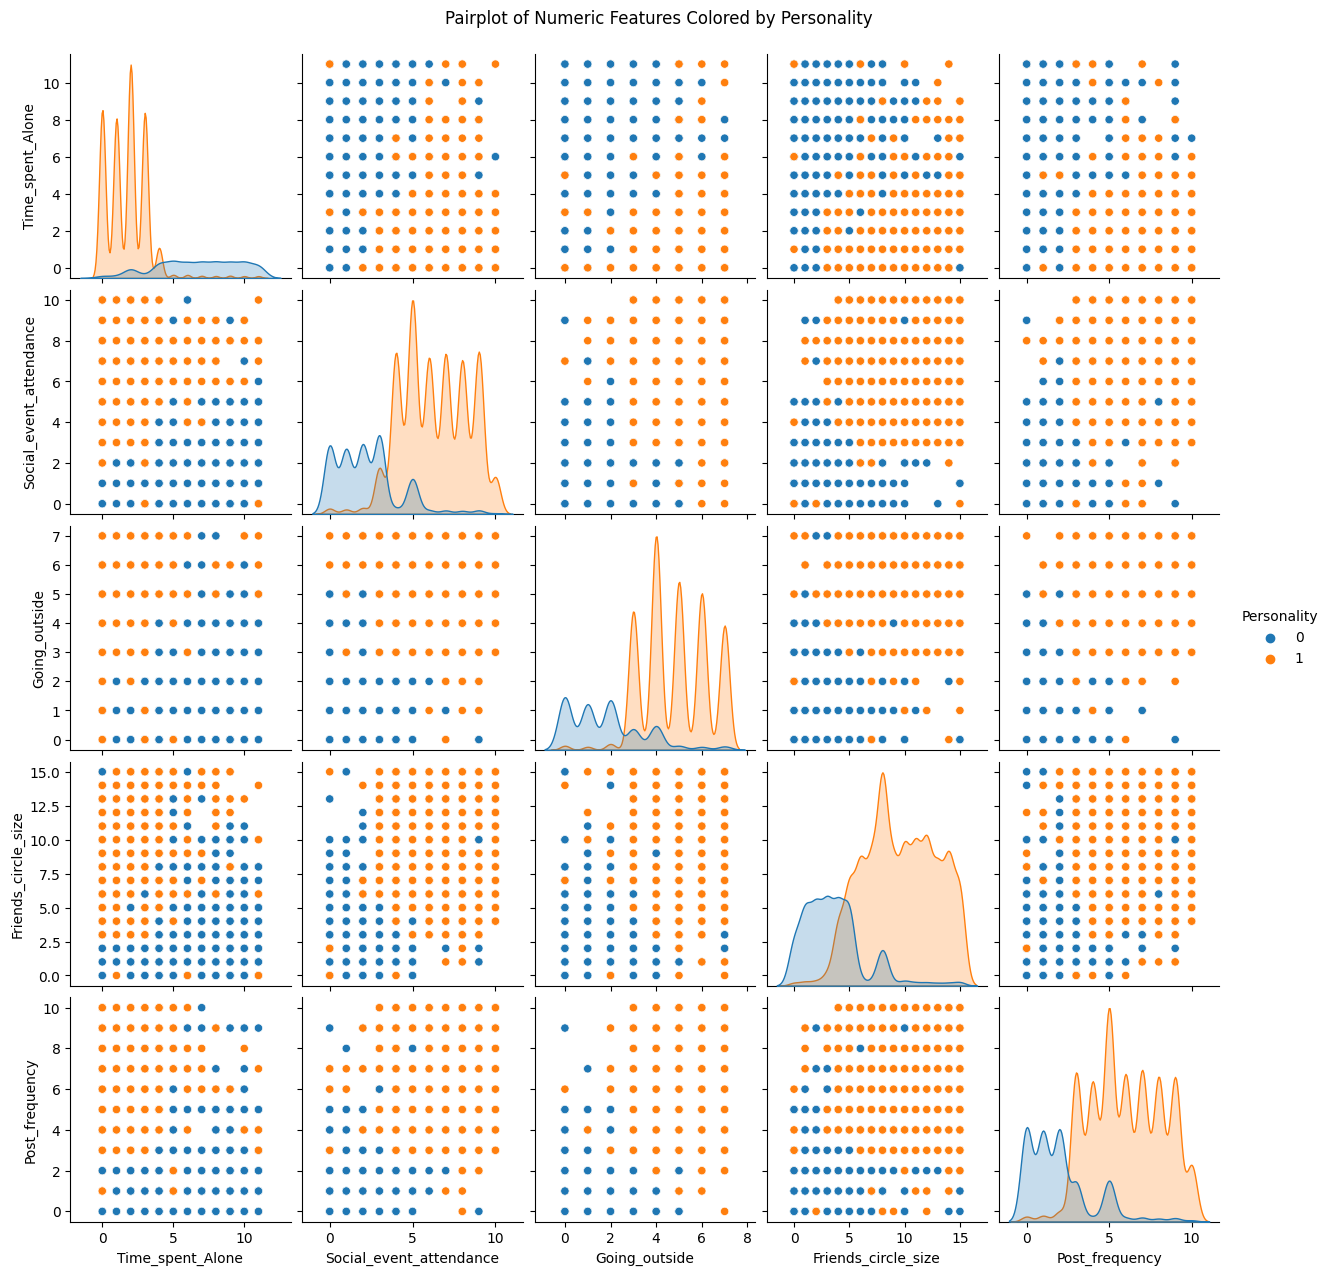

In [142]:
sns.pairplot(train_df, hue='Personality', vars=numeric_cols)
plt.suptitle('Pairplot of Numeric Features Colored by Personality', y=1.02)
plt.show()

Countplots of Binary Features

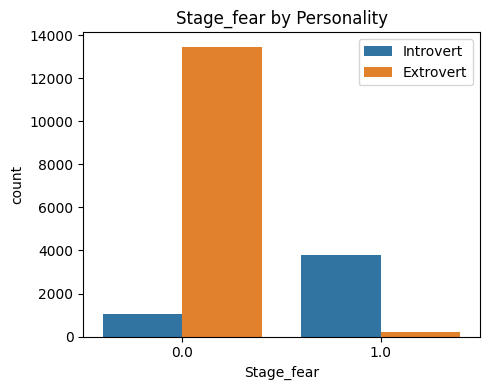

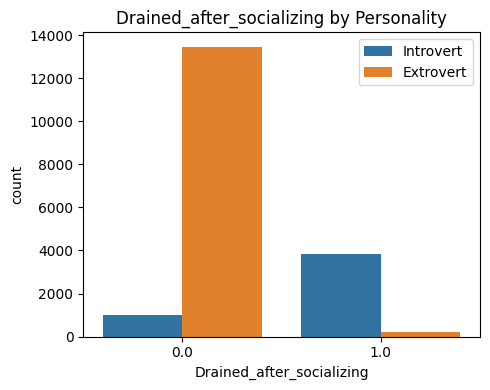

In [143]:
for col in ['Stage_fear', 'Drained_after_socializing']:
    plt.figure(figsize=(5, 4))
    sns.countplot(x=col, hue='Personality', data=train_df)
    plt.title(f'{col} by Personality')
    plt.legend(labels=['Introvert', 'Extrovert'])
    plt.tight_layout()
    plt.show()

***Boxplots: Distribution by Personality***

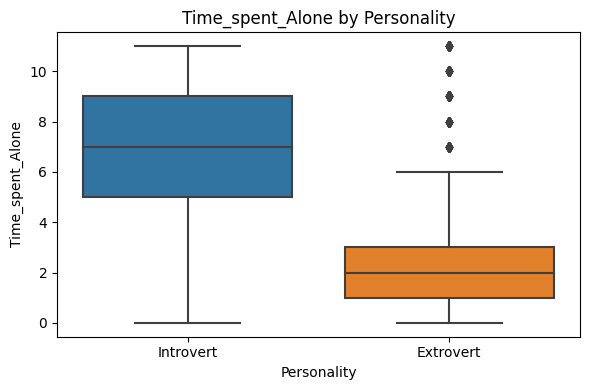

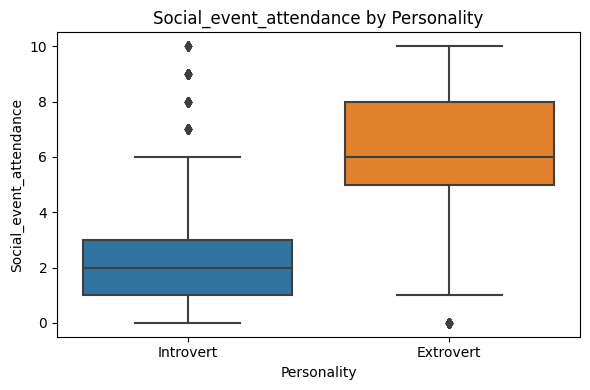

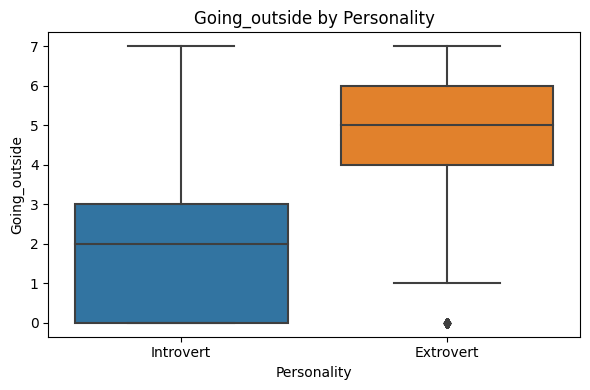

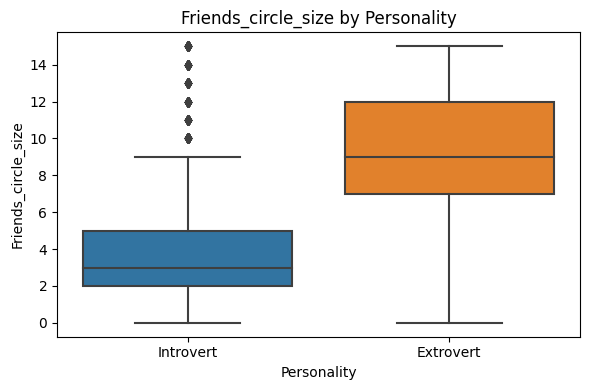

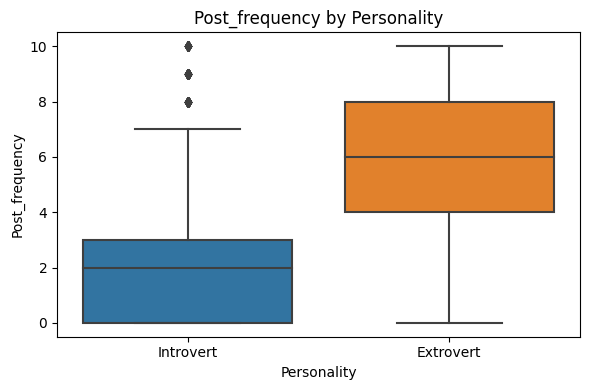

In [144]:
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Personality', y=col, data=train_df)
    plt.xticks([0, 1], ['Introvert', 'Extrovert'])
    plt.title(f'{col} by Personality')
    plt.tight_layout()
    plt.show()

***Histograms / KDE Plots by Class***

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


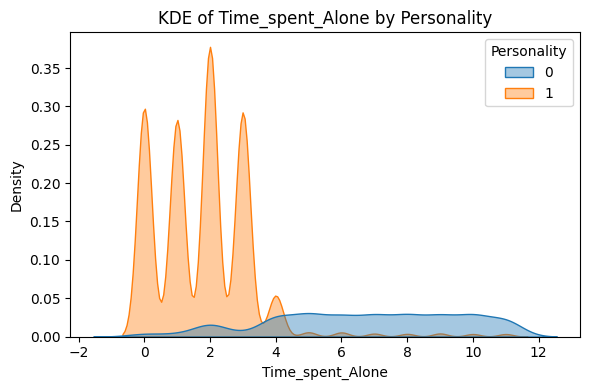

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


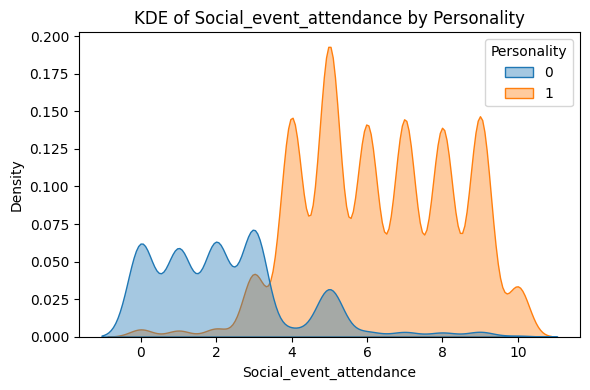

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


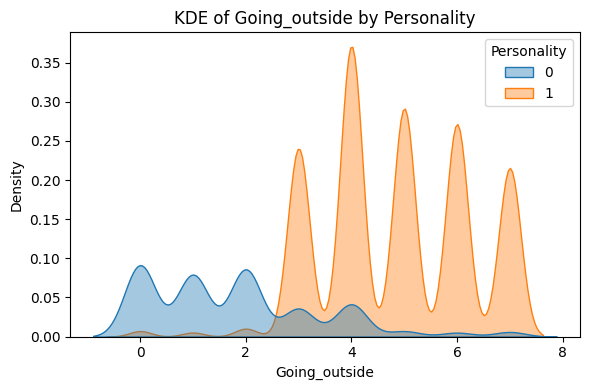

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


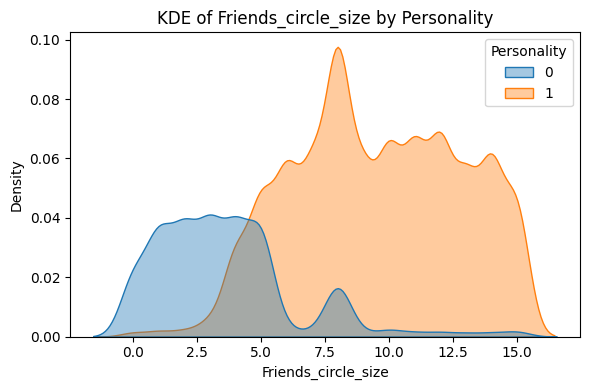

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


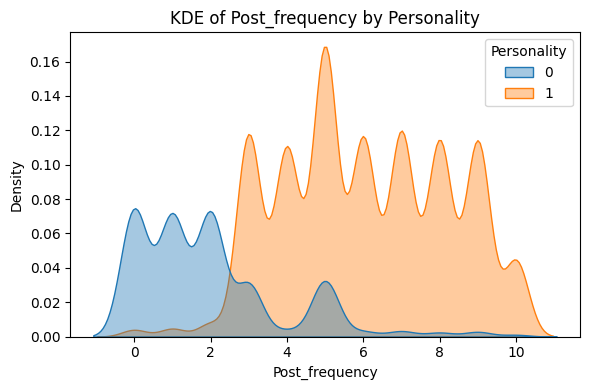

In [145]:
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=train_df, x=col, hue='Personality', fill=True, alpha=0.4)
    plt.title(f'KDE of {col} by Personality')
    plt.tight_layout()
    plt.show()

Standardize

In [146]:
# List of continuous columns to scale
scale_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
              'Friends_circle_size', 'Post_frequency']

# Initialize scaler
scaler = StandardScaler()

# Apply to train set
train_df[scale_cols] = scaler.fit_transform(train_df[scale_cols])
test_df[scale_cols] = scaler.fit_transform(test_df[scale_cols])

In [147]:
# Separate features and target
X = train_df.drop(columns=['Personality'])
y = train_df['Personality']

In [148]:
y.value_counts(normalize=True)

Personality
1    0.739527
0    0.260473
Name: proportion, dtype: float64

***Handle Class Imbalance***

In [149]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = dict(zip(np.unique(y), class_weights))
print("Class weights:", class_weights)

Class weights: {0: 1.9195854922279794, 1: 0.6761077450908826}


***Define a Function to Build the Keras Model***

In [150]:
def build_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),  
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


***Train with Stratified Cross-Validation***

In [151]:
# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
all_accuracies = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n📂 Fold {fold}")
    
    # Split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Re-initialize model each fold
    model = build_model(input_dim=X.shape[1])
    
    # Early stopping to prevent overfitting
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=8,
        batch_size=32,
        class_weight=class_weights,
        verbose=1
    )
    
    # Evaluate
    val_preds = model.predict(X_val)
    val_preds = (val_preds > 0.5).astype(int).flatten()
    acc = accuracy_score(y_val, val_preds)
    
    print(f"✅ Fold {fold} Accuracy: {acc:.4f}")
    all_accuracies.append(acc)
    fold += 1



📂 Fold 1
Epoch 1/8
464/464 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9186 - loss: 0.3325 - val_accuracy: 0.9684 - val_loss: 0.1698
Epoch 2/8
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9700 - loss: 0.1772 - val_accuracy: 0.9684 - val_loss: 0.1605
Epoch 3/8
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9685 - loss: 0.1793 - val_accuracy: 0.9690 - val_loss: 0.1524
Epoch 4/8
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9699 - loss: 0.1772 - val_accuracy: 0.9687 - val_loss: 0.1514
Epoch 5/8
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9682 - loss: 0.1756 - val_accuracy: 0.9684 - val_loss: 0.1567
Epoch 6/8
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9684 - loss: 0.1710 - val_accuracy: 0.9687 - val_loss: 0.1474
Epoch 7/8
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9683 - loss: 0.1664 - val_accuracy: 0.9684 - val_loss: 0.1535
Epoch 8/8
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9667 - loss: 0.1827 - val_accuracy: 

***Training Final Model on Full Training Set***

In [152]:
# Store predictions from each fold
test_preds_all = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n📂 Fold {fold}")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = build_model(input_dim=X.shape[1])
    
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=8,
        batch_size=32,
        class_weight=class_weights,
        verbose=1
    )
    
    # Validation accuracy
    val_preds = model.predict(X_val)
    val_preds = (val_preds > 0.5).astype(int).flatten()
    acc = accuracy_score(y_val, val_preds)
    print(f"✅ Fold {fold} Accuracy: {acc:.4f}")
    all_accuracies.append(acc)
    
    # Predict on test set for this fold and store
    test_fold_preds = model.predict(test_df)
    test_preds_all.append(test_fold_preds)
    
    fold += 1


📂 Fold 6
Epoch 1/8
464/464 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8963 - loss: 0.3155 - val_accuracy: 0.9692 - val_loss: 0.1703
Epoch 2/8
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9710 - loss: 0.1772 - val_accuracy: 0.9692 - val_loss: 0.1613
Epoch 3/8
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9670 - loss: 0.1914 - val_accuracy: 0.9692 - val_loss: 0.1476
Epoch 4/8
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9704 - loss: 0.1697 - val_accuracy: 0.9692 - val_loss: 0.1671
Epoch 5/8
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9695 - loss: 0.1771 - val_accuracy: 0.9690 - val_loss: 0.1530
Epoch 6/8
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9673 - loss: 0.1781 - val_accuracy: 0.9690 - val_loss: 0.1559
Epoch 7/8
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9689 - loss: 0.1733 - val_accuracy: 0.9690 - val_loss: 0.1580
Epoch 8/8
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9692 - loss: 0.1702 - val_accuracy: 

In [153]:
# Convert list of arrays to a matrix
test_preds_avg = np.mean(test_preds_all, axis=0)

# Final binary prediction
test_preds_final = (test_preds_avg > 0.5).astype(int).flatten()

In [154]:
# Train on full data
final_model = build_model(input_dim=X.shape[1])
final_model.fit(X, y, epochs=8, batch_size=32, class_weight=class_weights)

# Predict
test_preds = final_model.predict(test_df)
test_preds = (test_preds > 0.5).astype(int).flatten()


Epoch 1/8
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8947 - loss: 0.2749
Epoch 2/8
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9698 - loss: 0.1785
Epoch 3/8
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9660 - loss: 0.1895
Epoch 4/8
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9680 - loss: 0.1752
Epoch 5/8
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9686 - loss: 0.1799
Epoch 6/8
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9678 - loss: 0.1760
Epoch 7/8
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9681 - loss: 0.1757
Epoch 8/8
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9694 - loss: 0.1721
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


***SUBMISSION***

In [155]:
# Re-convert predictions to string labels
submission = pd.DataFrame({
    "id": test_ids,
    "Personality": test_preds
})

# Map integer predictions back to class labels
submission["Personality"] = submission["Personality"].map({1: "Extrovert", 0: "Introvert"})

# Save the submission file
submission.to_csv("submission.csv", index=False)


In [156]:
print(submission)

         id Personality
0     18524   Extrovert
1     18525   Introvert
2     18526   Extrovert
3     18527   Extrovert
4     18528   Introvert
...     ...         ...
6170  24694   Extrovert
6171  24695   Introvert
6172  24696   Extrovert
6173  24697   Extrovert
6174  24698   Introvert

[6175 rows x 2 columns]
